# Downloading Fermi Solar Flare Data

Let's download some Fermi flares.

In [175]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('talk')

import numpy as np
import pandas as pd

import astropy.io.fits as fits

import datetime

Now we can read in the catalog:

In [12]:
datadir = "/Users/danielahuppenkothen/work/data/solarflares/fermi/"

The file I use is [this one](https://hesperia.gsfc.nasa.gov/fermi/gbm/qlook/fermi_gbm_flare_list.txt) (generated on 2018/05/30), stripped of all unnecessary text that would confuse the ascii parser in pandas.

Let's define the column names by hand. I don't need the last two.

For reference:
* `id`: the solar flare catalog ID
* `date`: the date of the observation
* `tstart`: start time in UT
* `tend`: end time in UT
* `tpeak`: peak time in UT
* `duration`: the duration of the flare in seconds
* `peak_rate`: the peak count rate
* `total_rate`: the integrated number of counts in the flare
* `det1` to `det4`: the ID of the sunward pointing Fermi/GBM NaI detectors

In [153]:
column_names = ["id", "date", "tstart", "tpeak", "tend", "duration", 
                "peak_rate", "total_rate", "det1", "det2", "det3", "det4"]

In [154]:
fermicat = pd.read_csv(datadir+"fermigbmcatalog.dat", sep="\s*", skiprows=1, 
                       usecols=[0,1,2,3, 4, 5, 6, 7, 8, 9, 10, 11], 
                       names=column_names,
                       index_col=False)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/io/parsers.py:2227: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/io/parsers.py:2229: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [155]:
fermicat.head()

,id,date,tstart,tpeak,tend,duration,peak_rate,total_rate,det1,det2,det3,det4
0,081102_2014,2-Nov-2008,20:14:55,20:15:07,20:16:12,78,3646,172685,n0,n3,n6,n1
1,081211_1142,11-Dec-2008,11:42:14,11:42:51,11:45:31,197,2408,90103,n5,n1,n3,n4
2,090706_1702,6-Jul-2009,17:02:53,17:03:10,17:05:13,139,2434,45224,n5,n1,n3,n4
3,091025_0216,25-Oct-2009,02:16:59,02:21:29,02:35:33,1114,3859,553653,n5,n1,n3,n4
4,091026_2246,26-Oct-2009,22:46:41,22:49:41,22:51:56,315,7237,187108,n5,n1,n3,n4


Awesome. The first (and most annoying) task is to convert the dates into Fermi Mission Elapsed Time (MET), which is effectively seconds since Jan 1 2001. 

In [156]:
tstart_new = np.array([fermicat.loc[i].date + " " + fermicat.loc[i].tstart for i in fermicat.index])

In [157]:
tend_new = np.array([fermicat.loc[i].date + " " + fermicat.loc[i].tend for i in fermicat.index])

In [158]:
fermicat.tstart = tstart_new
fermicat.tend = tend_new

In [159]:
fermicat.head()

,id,date,tstart,tpeak,tend,duration,peak_rate,total_rate,det1,det2,det3,det4
0,081102_2014,2-Nov-2008,2-Nov-2008 20:14:55,20:15:07,2-Nov-2008 20:16:12,78,3646,172685,n0,n3,n6,n1
1,081211_1142,11-Dec-2008,11-Dec-2008 11:42:14,11:42:51,11-Dec-2008 11:45:31,197,2408,90103,n5,n1,n3,n4
2,090706_1702,6-Jul-2009,6-Jul-2009 17:02:53,17:03:10,6-Jul-2009 17:05:13,139,2434,45224,n5,n1,n3,n4
3,091025_0216,25-Oct-2009,25-Oct-2009 02:16:59,02:21:29,25-Oct-2009 02:35:33,1114,3859,553653,n5,n1,n3,n4
4,091026_2246,26-Oct-2009,26-Oct-2009 22:46:41,22:49:41,26-Oct-2009 22:51:56,315,7237,187108,n5,n1,n3,n4


In [160]:
fermicat.tstart = pd.to_datetime(fermicat.tstart)

In [161]:
fermicat.tend = pd.to_datetime(fermicat.tend)

Sometimes flares cross date lines, in which case the whole thing above goes to hell. 

Let's fix those cases:

In [176]:
for i in fermicat.index:
    dt = fermicat.loc[i, "tend"] - fermicat.loc[i, "tstart"]
    dt = dt.total_seconds()
    
    if dt < 0:
        fermicat.loc[i, "tend"] = fermicat.loc[i, "tend"] + datetime.timedelta(days=1)
    

In [179]:
met_start = datetime.datetime(2001, 1, 1, 0, 0, 0)

In [180]:
dt_tstart = np.array([fermicat.loc[i].tstart - met_start for i in fermicat.index])

In [181]:
dt_tend = np.array([fermicat.loc[i].tend - met_start for i in fermicat.index])

In [182]:
met_tstart = np.array([dt.total_seconds() for dt in dt_tstart])
met_tend = np.array([dt.total_seconds() for dt in dt_tend])

In [183]:
met_tstart

array([2.47349695e+08, 2.50688534e+08, 2.68592573e+08, ...,
       5.39707078e+08, 5.40004036e+08, 5.44089600e+08])

In [184]:
fermicat["met_tstart"] = pd.Series(met_tstart)

In [185]:
fermicat["met_tend"] = pd.Series(met_tend)

In [187]:
dt = fermicat["met_tend"] - fermicat["met_tstart"]

In [188]:
dt[dt < 0]

Series([], dtype: float64)

Awesome, that worked! I now have times in MET. Woo!

Next, I need to download the relevant data products. I'm going to want daily photon events for the relevant detectors and cut them into the right pieces. I'm probably not going to bother with barycentering for now?

But I should probably download the position history file just in case. 

In [209]:
from ftplib import FTP

In [191]:
f = fermicat.loc[0]

I need to fix the date format (again), so that I can download the data from the FTP server correctly:

In [204]:
year = str(f.tstart.year)
if f.tstart.month < 10:
    month = "0" + str(f.tstart.month)
else:
    month = str(f.tstart.month)
    
if f.tstart.day < 10:
    day = "0" + str(f.tstart.day)
else:
    day = str(f.tstart.day)
    
if f.tstart.hour < 10:
    hour = "0" + str(f.tstart.hour)
else:
    hour = str(f.tstart.hour)

In [205]:
hour

'20'

Let's now convert this into a path:

In [206]:
path = 'ftp://legacy.gsfc.nasa.gov/fermi/data/gbm/daily/' + year + "/" + month + "/" + day + "/current/"

In [207]:
path

'ftp://legacy.gsfc.nasa.gov/fermi/data/gbm/daily/2008/11/02/current/'

In [255]:
# open ftp connection
ft = FTP('legacy.gsfc.nasa.gov', "anonymous", "anonymous")
# move to the correct folder
ft.cwd('fermi/data/gbm/daily/' + year + "/" + month + "/" + day + "/current/")
# read out a list of files
files = ft.nlst()
# get all CTIME files
ctime = [x for x in files if 'ctime' in x]

# get the files for the correct detectors
det1_file = [x for x in ctime if f.det1 in x][0]
det2_file = [x for x in ctime if f.det2 in x][0]
det3_file = [x for x in ctime if f.det3 in x][0]
det4_file = [x for x in ctime if f.det4 in x][0]

# print the file names

print(det1_file)
print(det2_file)
print(det3_file)
print(det4_file)

# get the data
localfile = open(datadir+det1_file, 'wb')
ft.retrbinary('RETR ' + det1_file, localfile.write, 1024)
localfile.close()

localfile = open(datadir+det2_file, 'wb')
ft.retrbinary('RETR ' + det2_file, localfile.write, 1024)
localfile.close()

localfile = open(datadir+det3_file, 'wb')
ft.retrbinary('RETR ' + det3_file, localfile.write, 1024)
localfile.close()

localfile = open(datadir+det4_file, 'wb')
ft.retrbinary('RETR ' + det4_file, localfile.write, 1024)
localfile.close()

ft.quit()


glg_ctime_n0_081102_v00.pha
glg_ctime_n3_081102_v00.pha
glg_ctime_n6_081102_v00.pha
glg_ctime_n1_081102_v00.pha


'221 Goodbye.'

Let's make a function that download the data for a single flare:

In [260]:
def download_ctime_flares(date, detectors, datadir="./"):
    """
    Download Fermi/GBM CTIME data for a given date and set of detectors.
    
    The ftp server address is: legacy.gsfc.nasa.gov
    The daily GBM data is in fermi/data/gbm/daily/
    Beyond that, there's a subfolder for each year that Fermi has been 
    operating, and within those a folder for each month, and within 
    each of those is a folder for each day.
    
    date : datetime object
        A datetime object with the date information
        
    detectors : list
        A list of Fermi/GBM NaI detector names as strings
        to download
        
    datadir : str
        The path to the directory where to store the downloaded data
    """
    # convert the datetime format into year, month and day strings
    # of the correct format for the file system structure on the 
    # ftp server
    year = str(date.year)
    
    if date.month < 10:
        month = "0" + str(date.month)
    else:
        month = str(date.month)

    if date.day < 10:
        day = "0" + str(date.day)
    else:
        day = str(date.day)

    # open ftp connection
    ft = FTP('legacy.gsfc.nasa.gov', "anonymous", "anonymous")
    # move to the correct folder
    ft.cwd('fermi/data/gbm/daily/' + year + "/" + month + "/" + day + "/current/")
    
    # read out a list of files
    files = ft.nlst()
    # get all CTIME files
    ctime = [x for x in files if 'ctime' in x]

    # get the files for the correct detectors
    detfiles = []
    for det in detectors:
        detf = [x for x in ctime if det in x][0]
        print(detf)
        detfiles.append(detf)
        
        localfile = open(datadir+detf, 'wb')
        ft.retrbinary('RETR ' + detf, localfile.write, 1024)
        localfile.close()

    ft.quit()
    
    return detfiles


In [261]:
date = f.tstart
detectors = [f.det1, f.det2, f.det3, f.det4]

detfiles = download_ctime_flares(date, detectors, datadir=datadir)

glg_ctime_n0_081102_v00.pha
glg_ctime_n3_081102_v00.pha
glg_ctime_n6_081102_v00.pha
glg_ctime_n1_081102_v00.pha


Okay, so I can download some files. Let's see what they look like:

In [294]:
for i, detf in enumerate(detfiles):
    hdulist = fits.open(datadir + detf)
    time = hdulist[2].data.field("TIME")

    # if it's the first file, initialize the counts array
    if i == 0:
        counts = hdulist[2].data.field("COUNTS")
    else:
        # otherwise add counts to the existing counts array
        counts += hdulist[2].data.field("COUNTS")
    
    hdulist.close()
    

Compute the length of each time interval:

In [295]:
dt = np.diff(time)

Each entry in the counts array has five elements, one for each energy bin, so let's sum over those:

In [296]:
counts_sum = np.sum(counts, axis=1)

Now we can cut to only the time of the burst:

In [297]:
s_ind = time.searchsorted(f.met_tstart)
e_ind = time.searchsorted(f.met_tend)

tnew = time[s_ind:e_ind] # time array for flare
cnew = counts_sum[s_ind:e_ind] # counts array for flare
dtnew = dt[s_ind:e_ind] # new array with time intervals for flare
crnew = cnew/dtnew  # count rate for flare

<IPython.core.display.Javascript object>


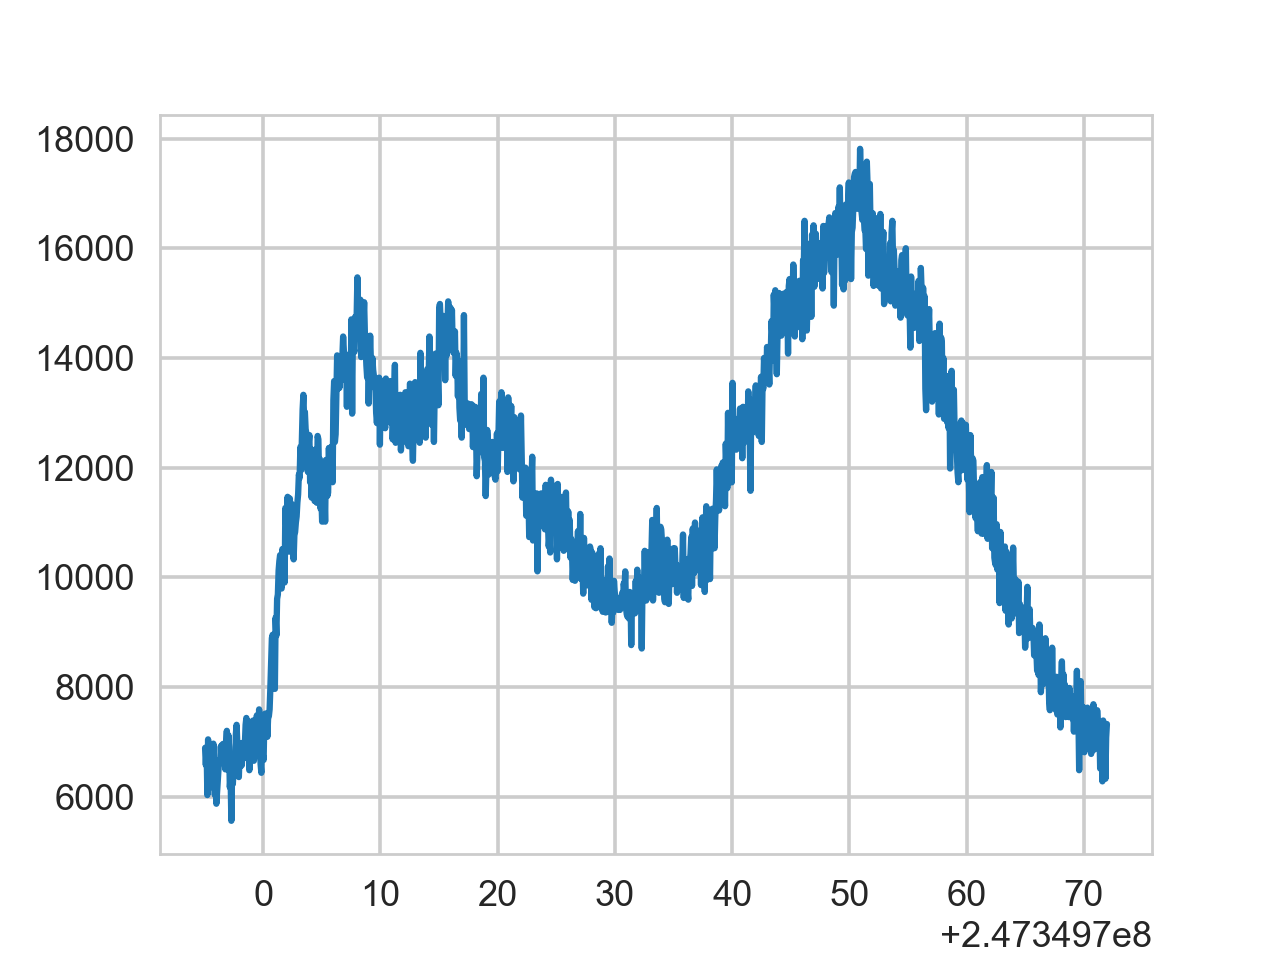

In [298]:
plt.figure()
#plt.plot(dt*10000)
plt.plot(time[s_ind:e_ind], counts_sum[s_ind:e_ind]/dt[s_ind:e_ind])

Awesome, let's make a function for this, too:

In [321]:
def extract_ctime_flare(detfiles, detectors, datadir="./"):
    # loop over detectors
    for i, detf in enumerate(detfiles):
        hdulist = fits.open(datadir + detf)
        time = hdulist[2].data.field("TIME")

        # if it's the first file, initialize the counts array
        if i == 0:
            counts = hdulist[2].data.field("COUNTS")
        else:
            # otherwise add counts to the existing counts array
            counts += hdulist[2].data.field("COUNTS")

        hdulist.close()

    dt = np.diff(time)
    counts_sum = np.sum(counts, axis=1)
    s_ind = time.searchsorted(f.met_tstart)
    e_ind = time.searchsorted(f.met_tend)

    tnew = time[s_ind:e_ind] # time array for flare
    cnew = counts_sum[s_ind:e_ind] # counts array for flare
    dtnew = dt[s_ind:e_ind] # new array with time intervals for flare
    crnew = cnew/dtnew  # count rate for flare
    
    # approximate uncertainties in count rate by a Gaussian distribution 
    # where mean == variance (i.e. std. deviation is sqrt of the mean)
    # note that we need to do that in *count* space, not *count rate* space
    # and then convert accordingly
    cerr = np.sqrt(cnew)
    cr_err = cerr/dtnew
    
    data = {"time": tnew, "counts": cnew, "countrate":crnew, "counts_err":cerr, 
           "countrate_err":cr_err, "dt":dtnew, "detfiles": detfiles}
    
    return data

In [322]:
data = extract_ctime_flare(detfiles, detectors, datadir=datadir)

<IPython.core.display.Javascript object>


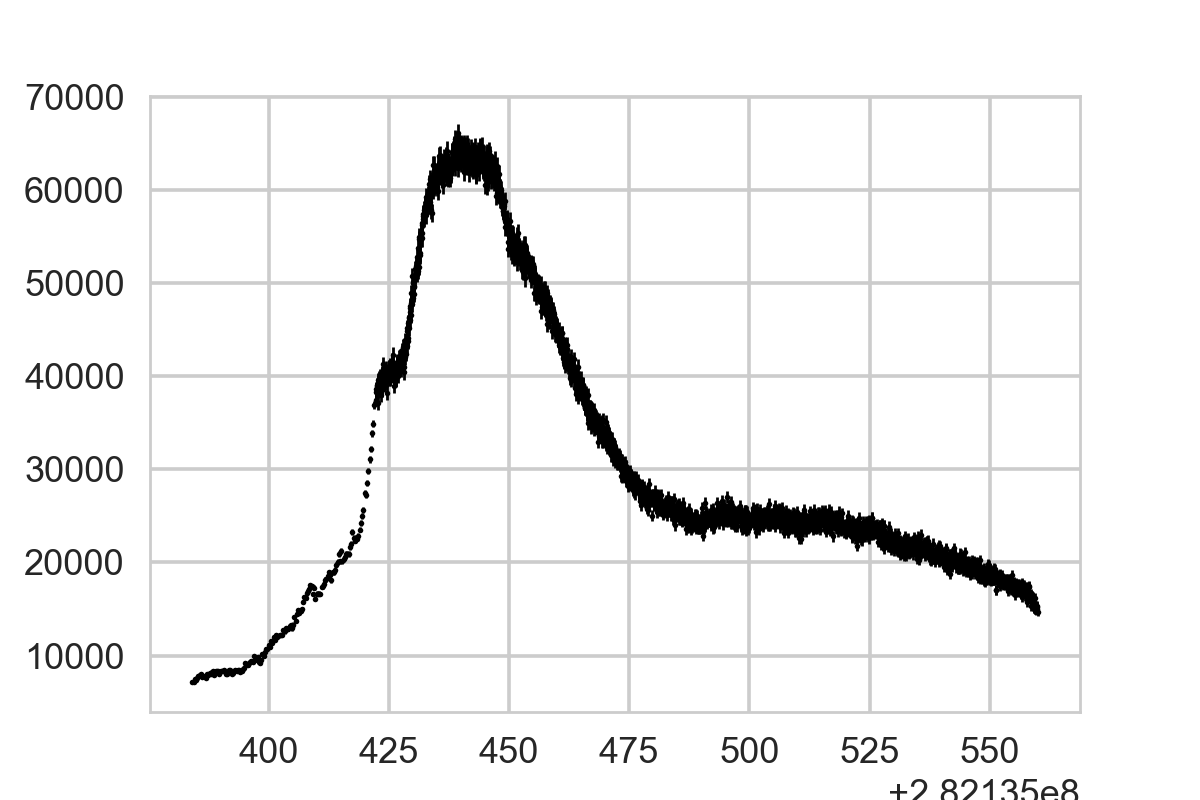

<Container object of 3 artists>

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.errorbar(data["time"], data["countrate"], yerr=data["countrate_err"], fmt="o", color="black",
           lw=1, markersize=2)

Let's try to do it for a bunch of flares:

In [313]:
fermicat[:10]

,id,date,tstart,tpeak,tend,duration,peak_rate,total_rate,det1,det2,det3,det4,met_tstart,met_tend
0,081102_2014,2-Nov-2008,2008-11-02 20:14:55,20:15:07,2008-11-02 20:16:12,78,3646,172685,n0,n3,n6,n1,247349695.0,247349772.0
1,081211_1142,11-Dec-2008,2008-12-11 11:42:14,11:42:51,2008-12-11 11:45:31,197,2408,90103,n5,n1,n3,n4,250688534.0,250688731.0
2,090706_1702,6-Jul-2009,2009-07-06 17:02:53,17:03:10,2009-07-06 17:05:13,139,2434,45224,n5,n1,n3,n4,268592573.0,268592713.0
3,091025_0216,25-Oct-2009,2009-10-25 02:16:59,02:21:29,2009-10-25 02:35:33,1114,3859,553653,n5,n1,n3,n4,278129819.0,278130933.0
4,091026_2246,26-Oct-2009,2009-10-26 22:46:41,22:49:41,2009-10-26 22:51:56,315,7237,187108,n5,n1,n3,n4,278290001.0,278290316.0
5,091027_0152,27-Oct-2009,2009-10-27 01:52:06,01:53:08,2009-10-27 01:55:23,197,9016,163409,n5,n1,n3,n4,278301126.0,278301323.0
6,091027_1014,27-Oct-2009,2009-10-27 10:14:23,10:16:46,2009-10-27 10:24:37,614,1931,160397,n5,n1,n3,n0,278331263.0,278331877.0
7,091027_1309,27-Oct-2009,2009-10-27 13:09:51,13:10:48,2009-10-27 13:13:07,197,3472,87347,n0,n3,n1,n6,278341791.0,278341987.0
8,091027_1936,27-Oct-2009,2009-10-27 19:36:39,19:37:14,2009-10-27 19:40:56,257,8006,522731,n0,n3,n1,n6,278364999.0,278365256.0
9,091210_1056,10-Dec-2009,2009-12-10 10:56:24,10:57:13,2009-12-10 10:59:20,176,19291,1003601,n5,n1,n3,n4,282135384.0,282135560.0


## Downloading this brightest bursts

I want to download the brightest bursts, or the ones with the most photons. 

Let's plot the peak counts and the total counts distributions:

<IPython.core.display.Javascript object>


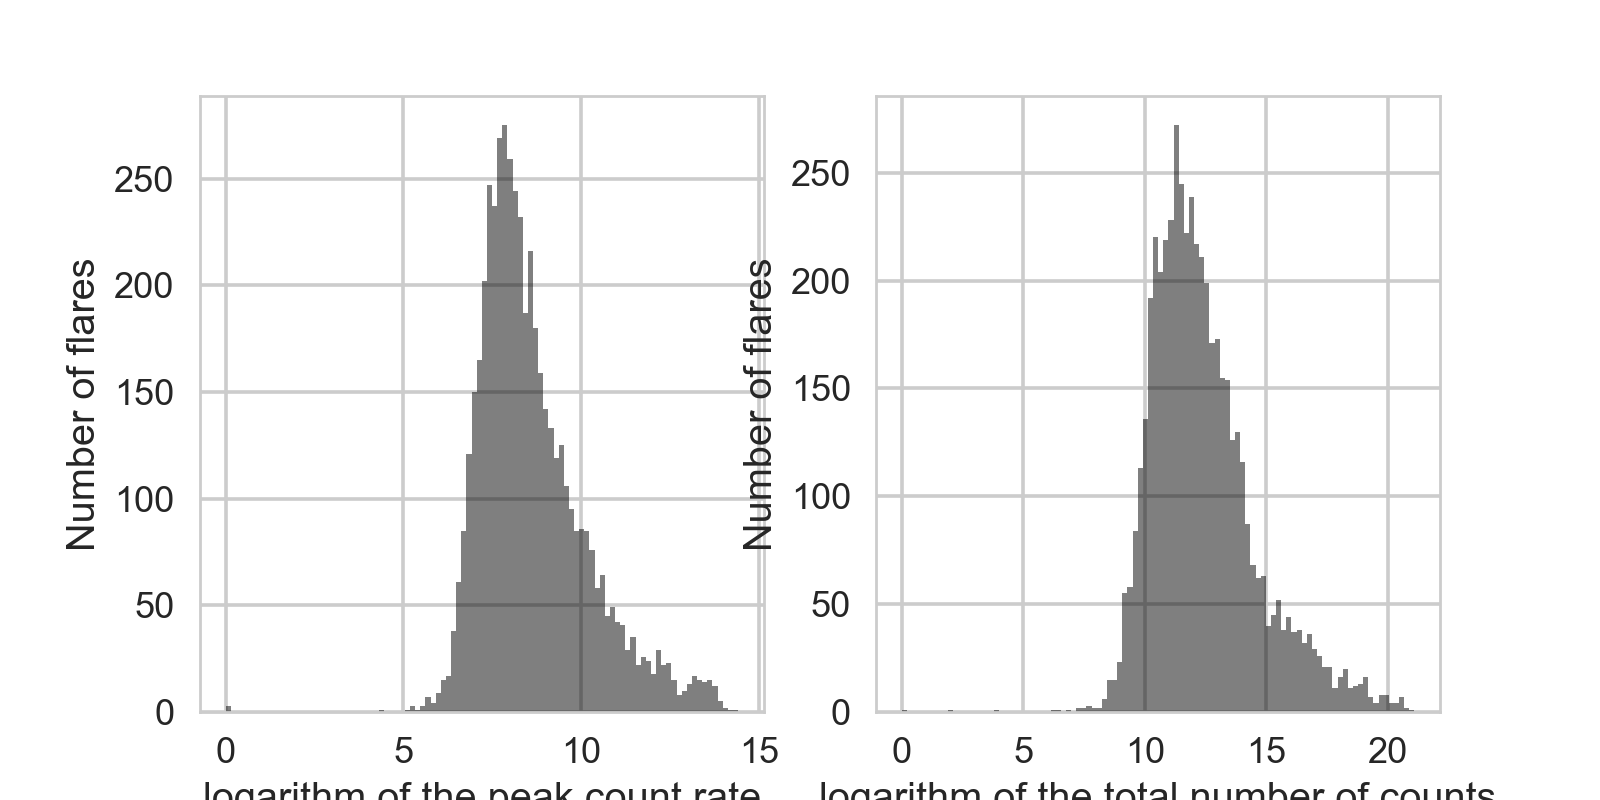

Text(0,0.5,'Number of flares')

In [343]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(np.log(fermicat["peak_rate"]), bins=100, histtype="stepfilled", 
         color="black", alpha=0.5)
ax1.set_xlabel("logarithm of the peak count rate")
ax1.set_ylabel("Number of flares")

ax2.hist(np.log(fermicat["total_rate"]), bins=100, histtype="stepfilled", 
         color="black", alpha=0.5)
ax2.set_xlabel("logarithm of the total number of counts")
ax2.set_ylabel("Number of flares")



There seems to be a small bump at high peak count rates that I'm not really sure I know the origin of. I'm going to focus on the bursts with the highest peak count rates and the overall hightest number of total counts (which also means they'll likely be long) to start with:

In [344]:
fermicat_bright = fermicat[(fermicat["total_rate"]> np.exp(17)) & (fermicat["total_rate"]> np.exp(12.5))]

In [345]:
len(fermicat_bright)

218

In [ ]:
data_all = []
for i in fermicat_bright.index:
    f = fermicat_bright.loc[i]
    date = f.tstart
    detectors = [f.det1, f.det2, f.det3, f.det4]
    
    detfiles = download_ctime_flares(date, detectors, datadir=datadir)
    data = extract_ctime_flare(detfiles, detectors, datadir=datadir)
    
    data["detectors"] =  detectors
    data_all.append(data)

glg_ctime_n5_100120_v00.pha
glg_ctime_n1_100120_v00.pha
glg_ctime_n3_100120_v00.pha
glg_ctime_n0_100120_v00.pha


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


glg_ctime_n5_100206_v00.pha
glg_ctime_n1_100206_v00.pha
glg_ctime_n3_100206_v00.pha
glg_ctime_n0_100206_v00.pha


<IPython.core.display.Javascript object>


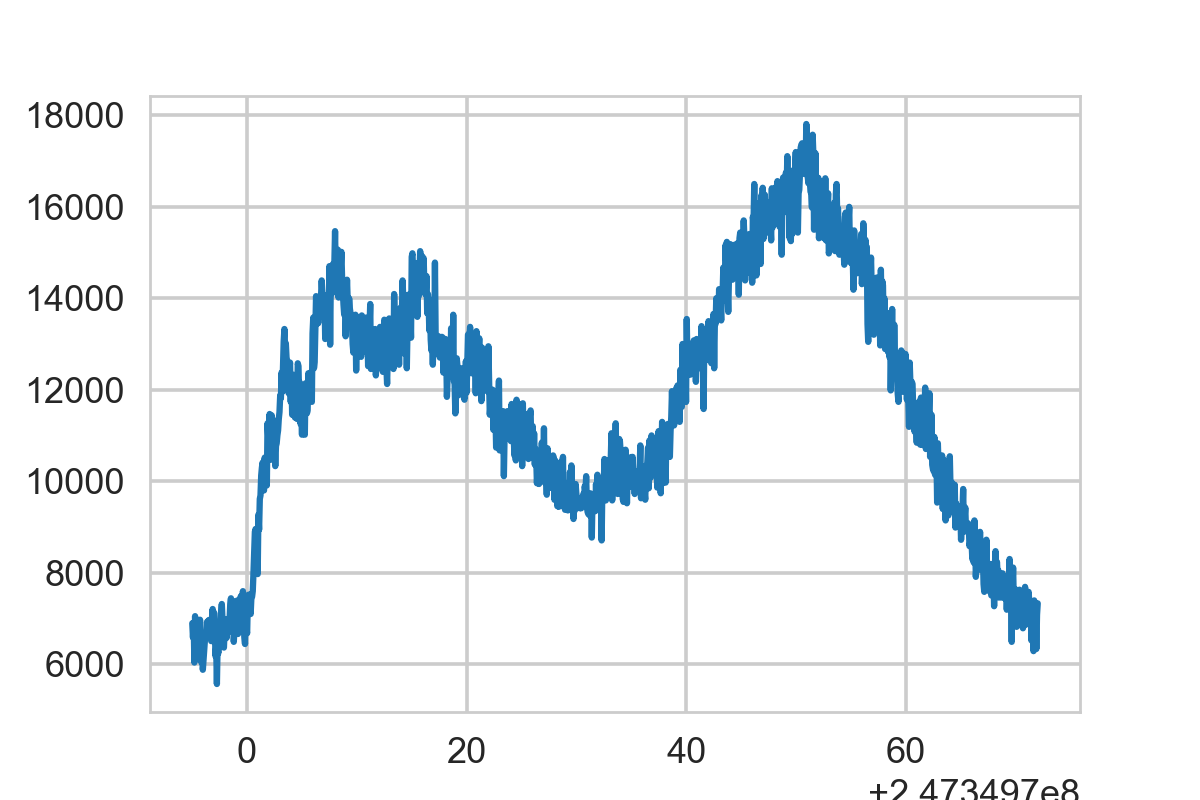

<IPython.core.display.Javascript object>


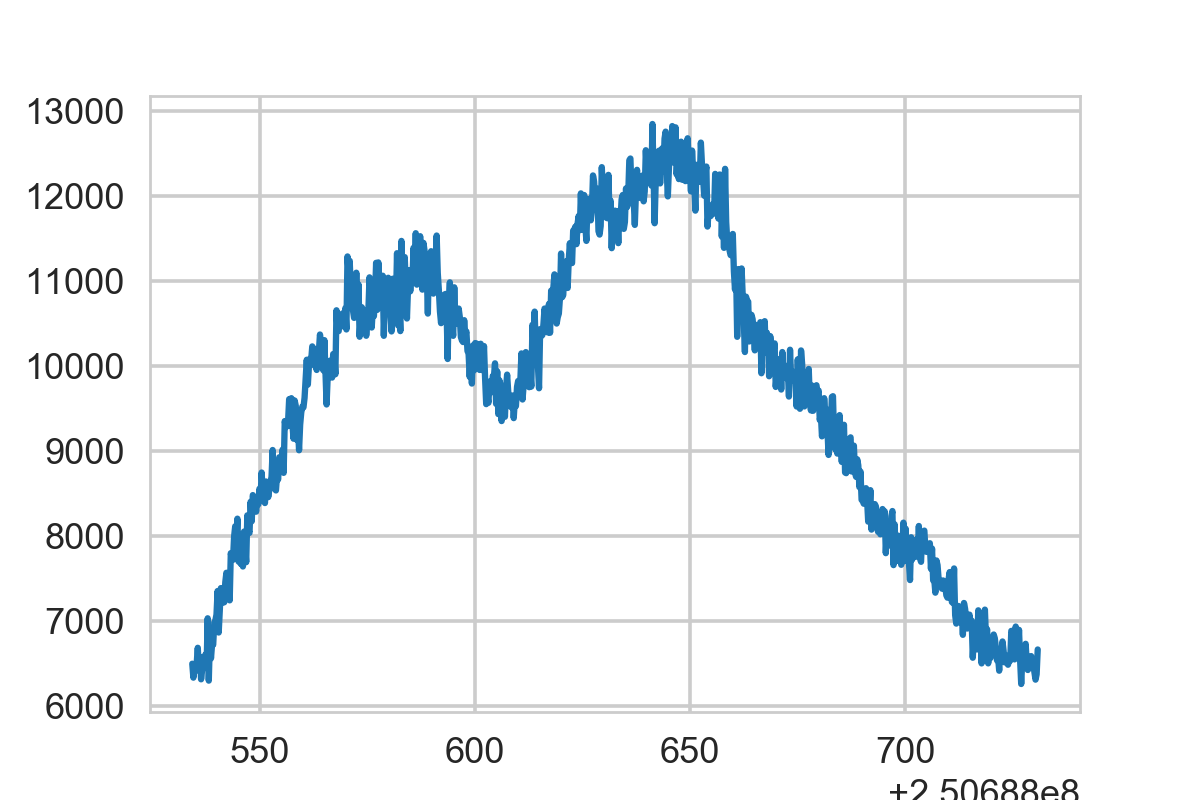

<IPython.core.display.Javascript object>


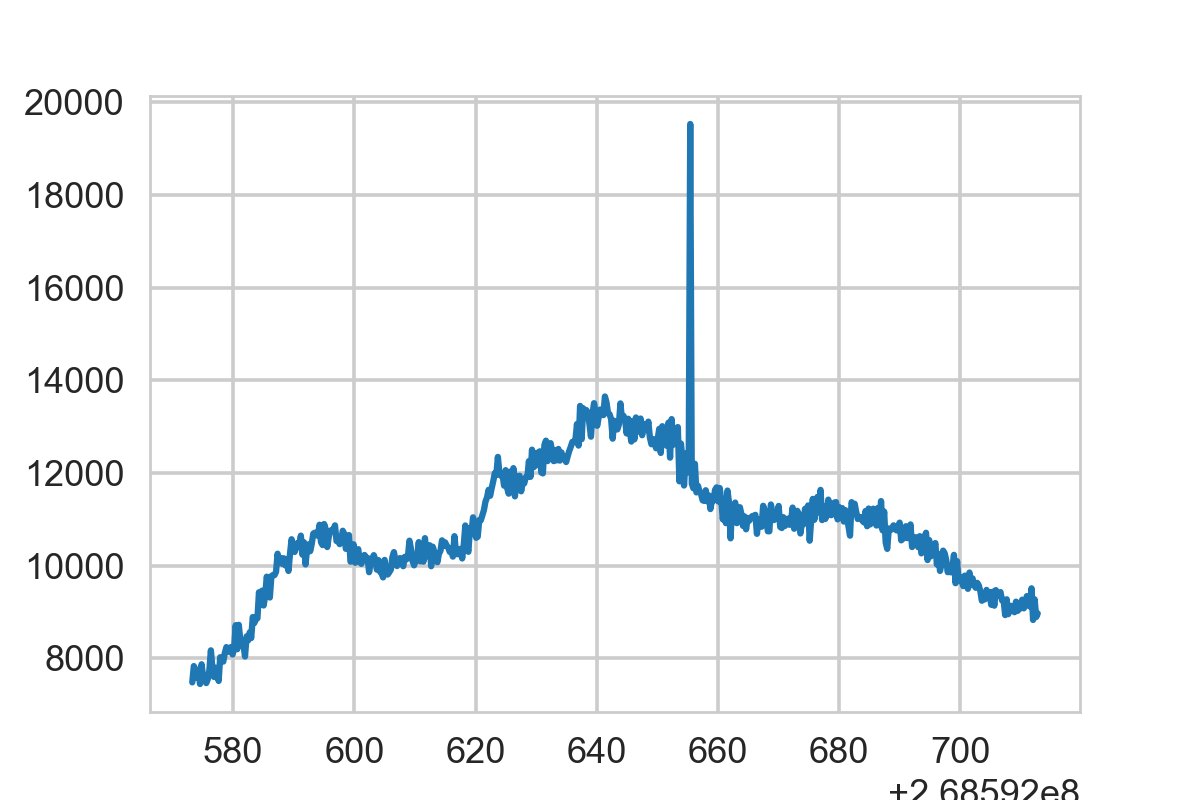

<IPython.core.display.Javascript object>


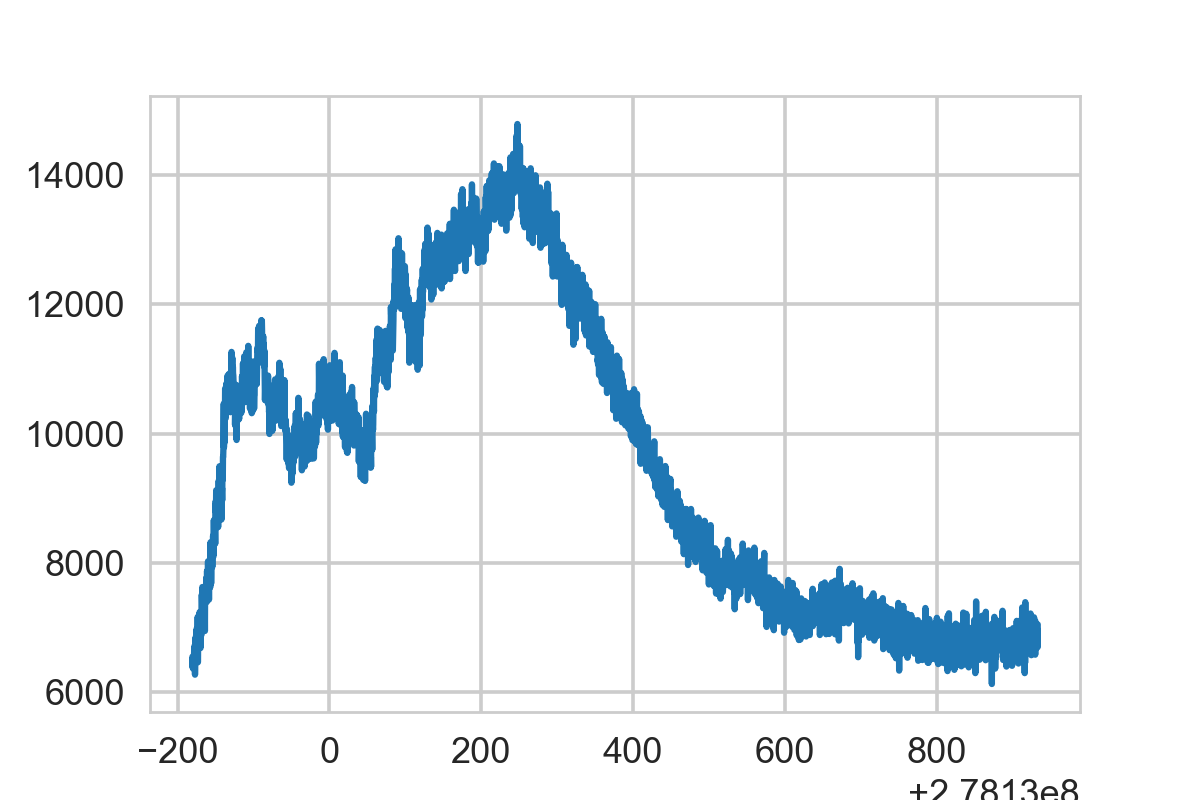

<IPython.core.display.Javascript object>


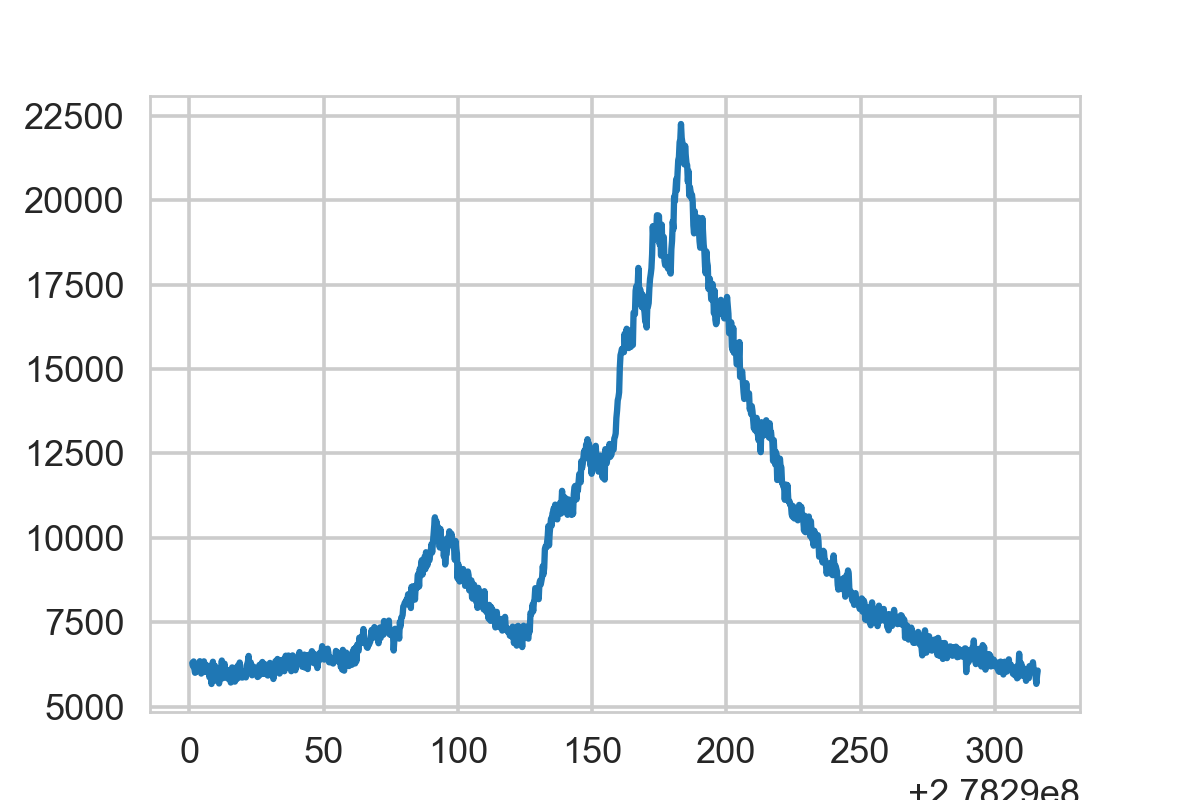

<IPython.core.display.Javascript object>


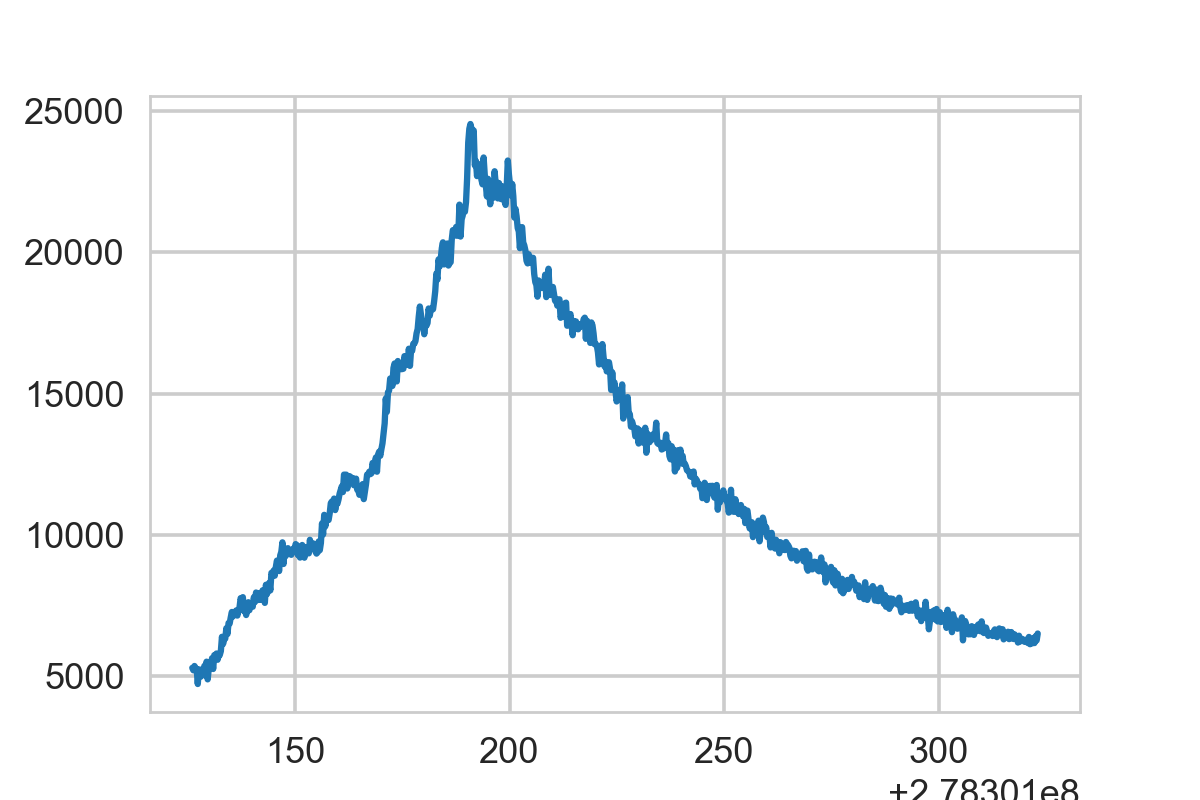

<IPython.core.display.Javascript object>


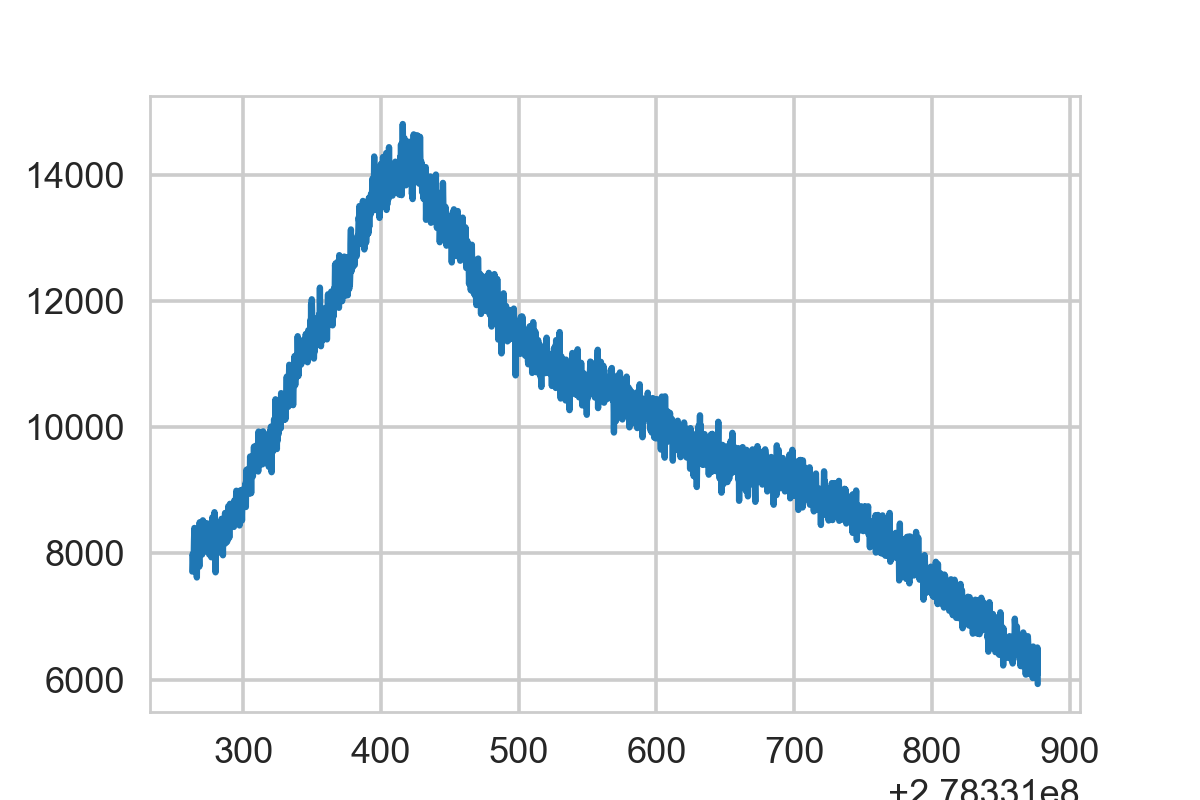

<IPython.core.display.Javascript object>


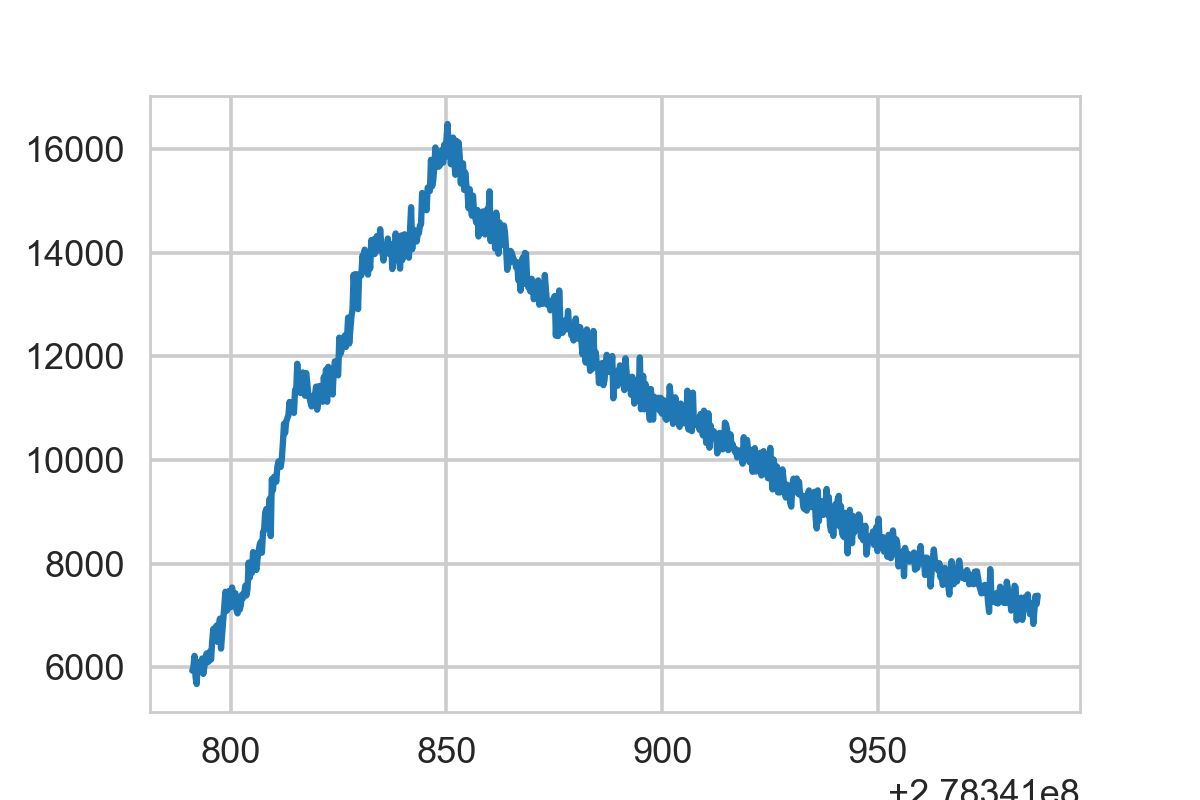

<IPython.core.display.Javascript object>


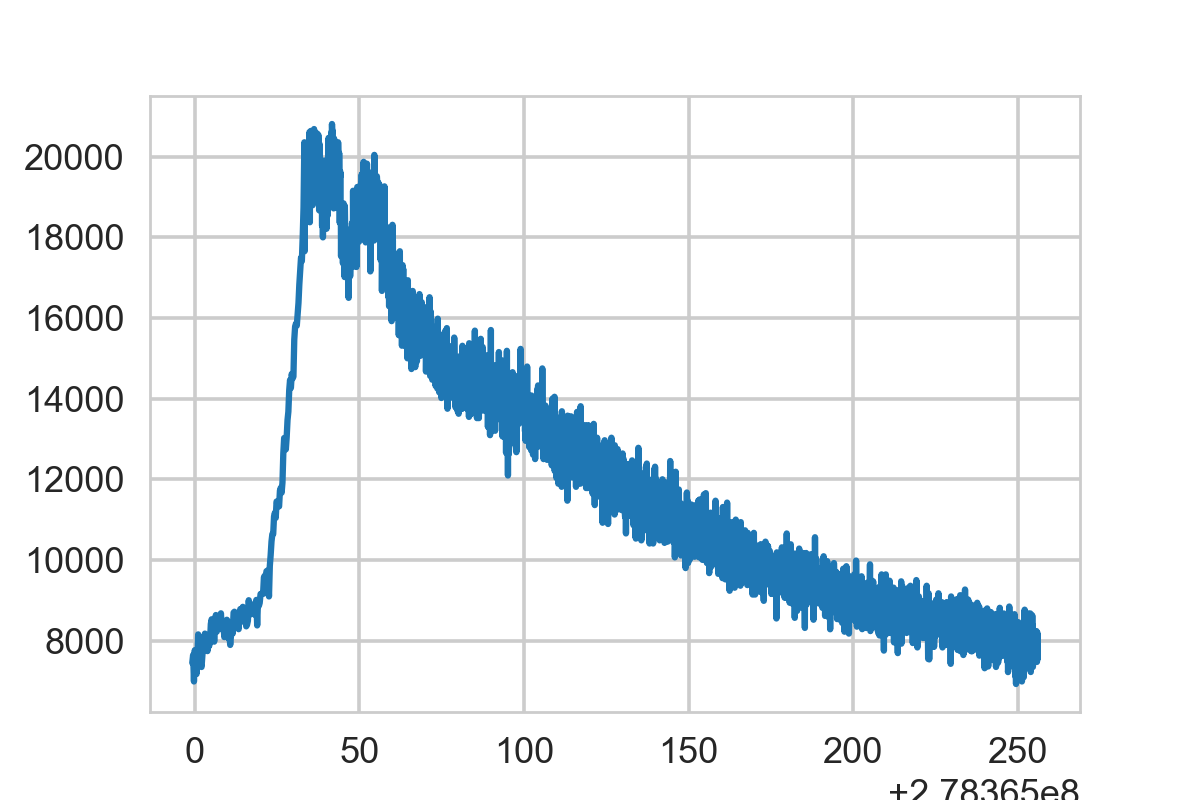

<IPython.core.display.Javascript object>


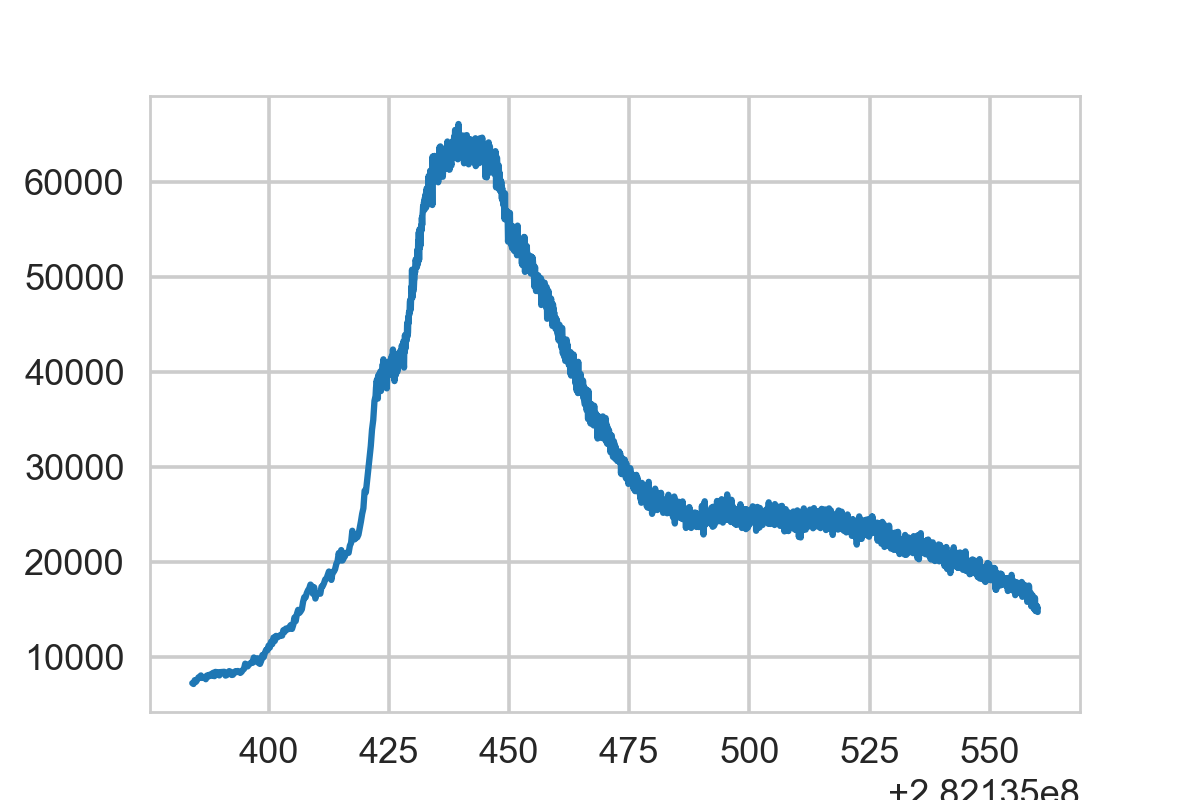

In [318]:
for d in data_all:
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.plot(d["time"], d["countrate"])